# Segmenter

- Model implematation: https://medium.com/@ashishbisht0307/swin-transformer-based-unet-architecture-for-semantic-segmentation-with-pytorch-code-91e779334e8e
- Paper: https://arxiv.org/abs/2105.05537


In [1]:
%pip install einops timm imutils torchvision lightning torchmetrics

  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 21.8 MB/s eta 0:00:00
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=5d906a8ca4214dbfe02259a3d6472f4ceee55d5257e6b59c256fceaddb108532
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    from utils import get_seg_lightning_modules, get_segmentation_plot, local_paths, kaggle_paths
except Exception as e:
    import sys
    sys.path.append("/kaggle/input/segmentation-util")
    from utils import get_seg_lightning_modules, get_segmentation_plot, local_paths, kaggle_paths

In [3]:
FAST = False # Fast dev: run 1 batch only
LOCAL = False
ACCELERATOR = 'gpu'

dataset_paths = local_paths if LOCAL else kaggle_paths

## Segmenter Model


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from timm.models.layers import trunc_normal_, DropPath
from timm.models.vision_transformer import _load_weights
from einops import rearrange

def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def resize_pos_embed(posemb, grid_old_shape, grid_new_shape, num_extra_tokens):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    posemb_tok, posemb_grid = (
        posemb[:, :num_extra_tokens],
        posemb[0, num_extra_tokens:],
    )
    if grid_old_shape is None:
        gs_old_h = int(math.sqrt(len(posemb_grid)))
        gs_old_w = gs_old_h
    else:
        gs_old_h, gs_old_w = grid_old_shape

    gs_h, gs_w = grid_new_shape
    posemb_grid = posemb_grid.reshape(1, gs_old_h, gs_old_w, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_h, gs_w), mode="bilinear")
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_h * gs_w, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb

def padding(im, patch_size, fill_value=0):
    # make the image sizes divisible by patch_size
    H, W = im.size(2), im.size(3)
    pad_h, pad_w = 0, 0
    if H % patch_size > 0:
        pad_h = patch_size - (H % patch_size)
    if W % patch_size > 0:
        pad_w = patch_size - (W % patch_size)
    im_padded = im
    if pad_h > 0 or pad_w > 0:
        im_padded = F.pad(im, (0, pad_w, 0, pad_h), value=fill_value)
    return im_padded


def unpadding(y, target_size):
    H, W = target_size
    H_pad, W_pad = y.size(2), y.size(3)
    # crop predictions on extra pixels coming from padding
    extra_h = H_pad - H
    extra_w = W_pad - W
    if extra_h > 0:
        y = y[:, :, :-extra_h]
    if extra_w > 0:
        y = y[:, :, :, :-extra_w]
    return y

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = dim
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads, dropout):
        super().__init__()
        self.heads = heads
        head_dim = dim // heads
        self.scale = head_dim ** -0.5
        self.attn = None

        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    @property
    def unwrapped(self):
        return self

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, C // self.heads)
            .permute(2, 0, 3, 1, 4)
        )
        
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
       

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
    
        return x, attn

class Block(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout, drop_path):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dropout)
        self.mlp = FeedForward(dim, mlp_dim, dropout)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x, mask=None, return_attention=False):
        x = self.norm1(x)

        y, attn = self.attn(x, mask)
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, channels):
        super().__init__()

        self.image_size = image_size
        if image_size[0] % patch_size != 0 or image_size[1] % patch_size != 0:
            raise ValueError("image dimensions must be divisible by the patch size")
        self.grid_size = image_size[0] // patch_size, image_size[1] // patch_size
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, im):
        B, C, H, W = im.shape
        x = self.proj(im).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, image_size=(512, 512), patch_size=16, n_layers=12, d_model=192, 
                 d_ff=192 * 4, n_heads=3, n_cls = 1000,
                 dropout=0.1, drop_path_rate=0.0, distilled=False, channels=3,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, d_model, channels)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.n_cls = n_cls

        # cls and pos tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.distilled = distilled
        if self.distilled:
            self.dist_token = nn.Parameter(torch.zeros(1, 1, d_model))
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 2, d_model)
            )
            self.head_dist = nn.Linear(d_model, n_cls)
        else:
            self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches + 1, d_model)
            )

        # transformer blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff, dropout, dpr[i]) for i in range(n_layers)]
        )

        # output head
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_cls)

        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        if self.distilled:
            trunc_normal_(self.dist_token, std=0.02)
        self.pre_logits = nn.Identity()

        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token", "dist_token"}

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=""):
        _load_weights(self, checkpoint_path, prefix)

    def forward(self, im, return_features=False):
        B, _, H, W = im.shape
        PS = self.patch_size

        x = self.patch_embed(im)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distilled:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.pos_embed
        num_extra_tokens = 1 + self.distilled
        if x.shape[1] != pos_embed.shape[1]:
            pos_embed = resize_pos_embed(
                pos_embed,
                self.patch_embed.grid_size,
                (H // PS, W // PS),
                num_extra_tokens,
            )
        x = x + pos_embed
        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        if return_features:
            return x

        if self.distilled:
            x, x_dist = x[:, 0], x[:, 1]
            x = self.head(x)
            x_dist = self.head_dist(x_dist)
            x = (x + x_dist) / 2
        else:
            x = x[:, 0]
            x = self.head(x)
        return x

    
class DecoderLinear(nn.Module):
    def __init__(self, patch_size=16, d_encoder=192, n_cls=2):
        super().__init__()

        self.d_encoder = d_encoder
        self.patch_size = patch_size
        self.n_cls = n_cls

        self.head = nn.Linear(self.d_encoder, n_cls)
        self.apply(init_weights)

    @torch.jit.ignore
    def no_weight_decay(self):
        return set()

    def forward(self, x, im_size):
        H, W = im_size
        GS = H // self.patch_size
        x = self.head(x)
        ## h*w = n
        x = rearrange(x, "b (h w) c -> b c h w", h=GS)

        return x
    
class Segmenter(nn.Module):
    def __init__(self, encoder, decoder, n_cls=2):
        super().__init__()
        self.n_cls = n_cls
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder

    @torch.jit.ignore
    def no_weight_decay(self):
        def append_prefix_no_weight_decay(prefix, module):
            return set(map(lambda x: prefix + x, module.no_weight_decay()))

        nwd_params = append_prefix_no_weight_decay("encoder.", self.encoder).union(
            append_prefix_no_weight_decay("decoder.", self.decoder)
        )
        return nwd_params

    def forward(self, im):
        H_ori, W_ori = im.size(2), im.size(3)
        im = padding(im, self.patch_size)
        H, W = im.size(2), im.size(3)

        x = self.encoder(im, return_features=True)
        # print("After decoder: ", x.shape)
        # remove CLS/DIST tokens for decoding
        num_extra_tokens = 1 + self.encoder.distilled
        x = x[:, num_extra_tokens:]

        masks = self.decoder(x, (H, W))

        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        masks = unpadding(masks, (H_ori, W_ori))

        return masks

## Shenzhen


In [5]:
s_dm, s_module, s_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['shenzen'],
    model_name='shenzen_segmenter',
    model=Segmenter(encoder=VisionTransformer(), decoder=DecoderLinear()),
    fast=FAST,
    accelerator=ACCELERATOR,
    devices=[0]
)

s_trainer.fit(s_module, s_dm)
s_trainer.test(s_module, s_dm)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Segmenter        | 5.9 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.507    Total estimated model params size (MB)


318 examples in the training set...
106 examples in the validation set...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


142 examples in the test set...


Testing: |          | 0/? [00:00<?, ?it/s]

f1: 0.8570887631093952
accuracy: 0.7507402393179881
precision: 0.7507402393179881
recall: 1.0
mean_iou: 0.7507402393179881


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5618616938591003     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5618616938591003}]

142 examples in the test set...


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

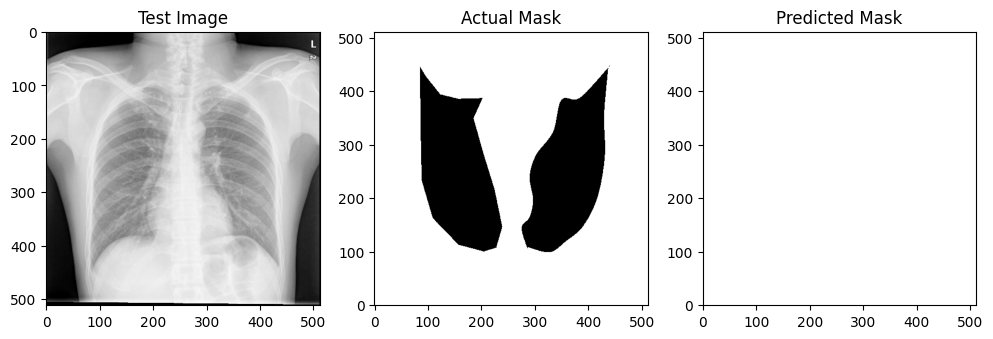

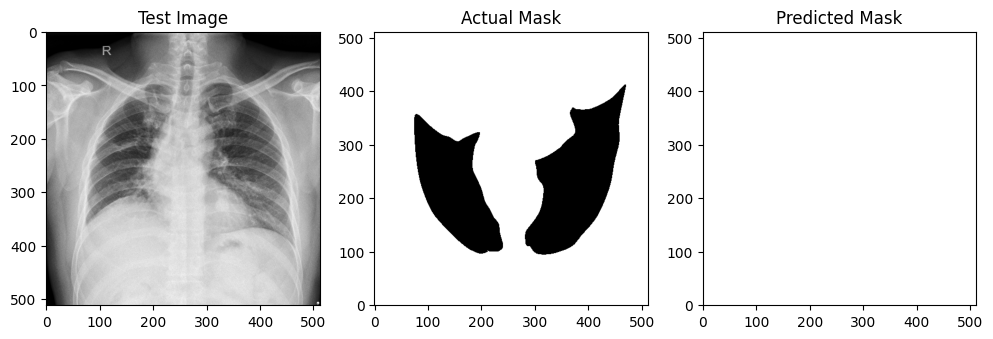

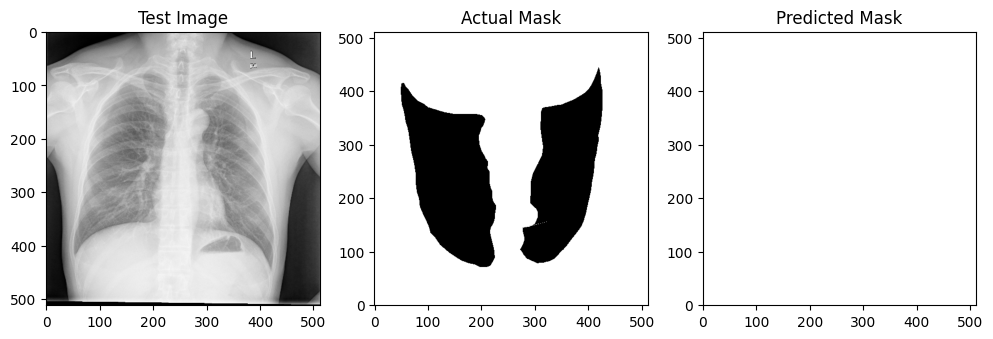

In [6]:
s_dm.setup('test')
get_segmentation_plot(
    s_module.model, 
    s_dm.test, 
    device='cpu')

## Darwin


In [7]:
d_dm, d_module, d_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['darwin'],
    model_name='darwin_segmenter',
    model=Segmenter(encoder=VisionTransformer(), decoder=DecoderLinear()),
    fast=FAST,
    accelerator=ACCELERATOR,
    devices=[0]
)

d_trainer.fit(d_module, d_dm)
d_trainer.test(d_module, d_dm)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Segmenter        | 5.9 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.507    Total estimated model params size (MB)


3434 examples in the training set...
1145 examples in the validation set...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


1527 examples in the test set...


Testing: |          | 0/? [00:00<?, ?it/s]

f1: 0.8048619962643578
accuracy: 0.6750884405605456
precision: 0.6750884405605456
recall: 1.0
mean_iou: 0.6750884405605456


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6310411691665649     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6310411691665649}]

1527 examples in the test set...


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

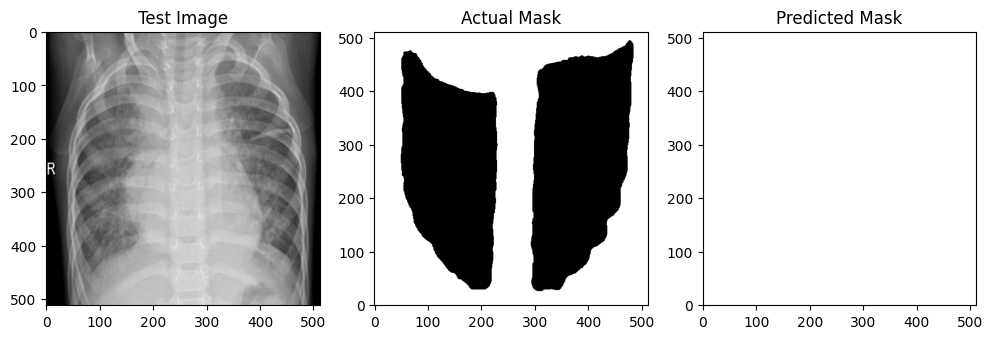

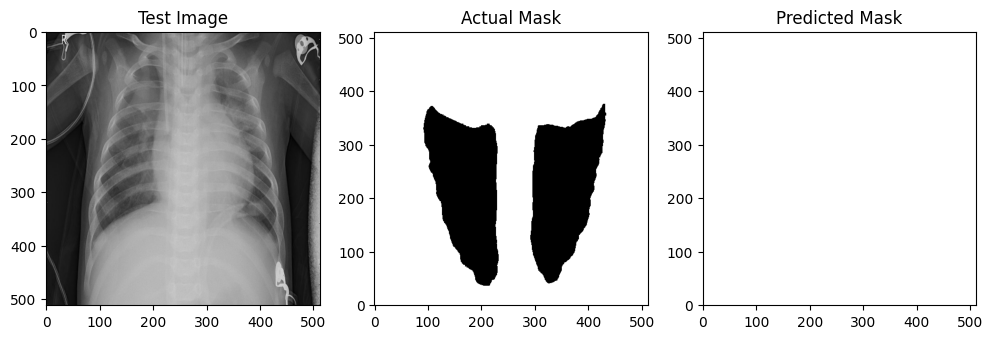

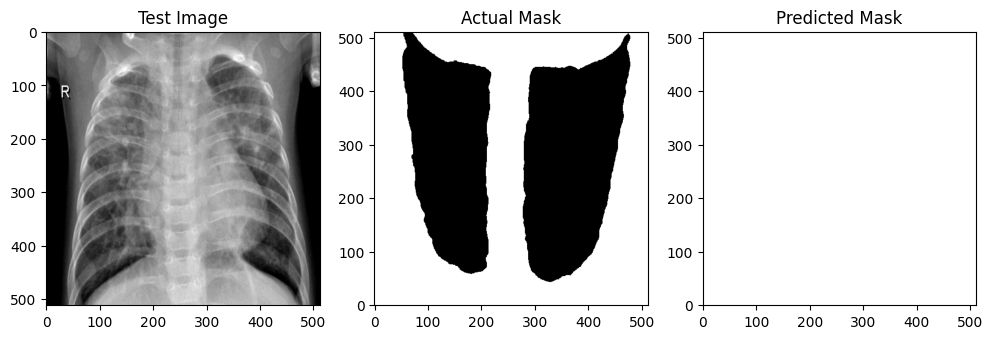

In [8]:
d_dm.setup('test')
get_segmentation_plot(
    d_module.model, 
    d_dm.test, 
    device='cpu')

## Covid


In [9]:
c_dm, c_module, c_trainer = get_seg_lightning_modules(
    data_paths=dataset_paths['covid'],
    model_name='covid_segmenter',
    model=Segmenter(encoder=VisionTransformer(image_size=(256, 256)), decoder=DecoderLinear()),
    fast=FAST,
    accelerator=ACCELERATOR,
    devices=[0]
)
c_trainer.fit(c_module, c_dm)
c_trainer.test(c_module, c_dm)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Segmenter        | 5.7 M  | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.917    Total estimated model params size (MB)


2034 examples in the training set...
678 examples in the validation set...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


904 examples in the test set...


Testing: |          | 0/? [00:00<?, ?it/s]

f1: 0.8593466852882267
accuracy: 0.7547999187908342
precision: 0.7547999187908342
recall: 1.0
mean_iou: 0.7547999187908342


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5583733916282654     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5583733916282654}]

904 examples in the test set...


[<Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>,
 <Figure size 1200x800 with 3 Axes>]

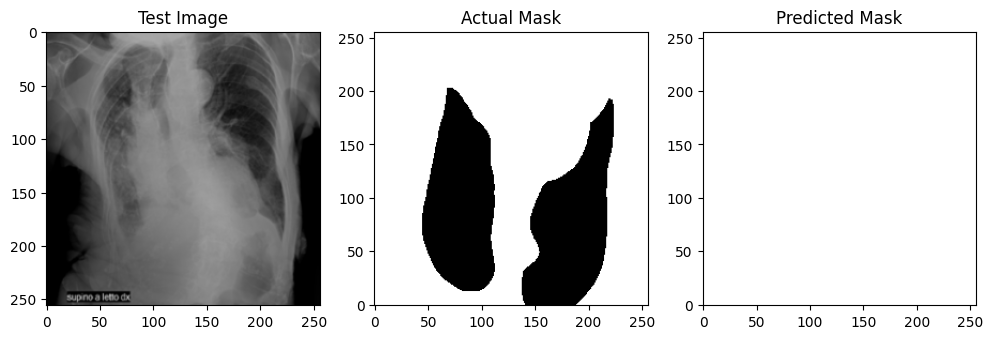

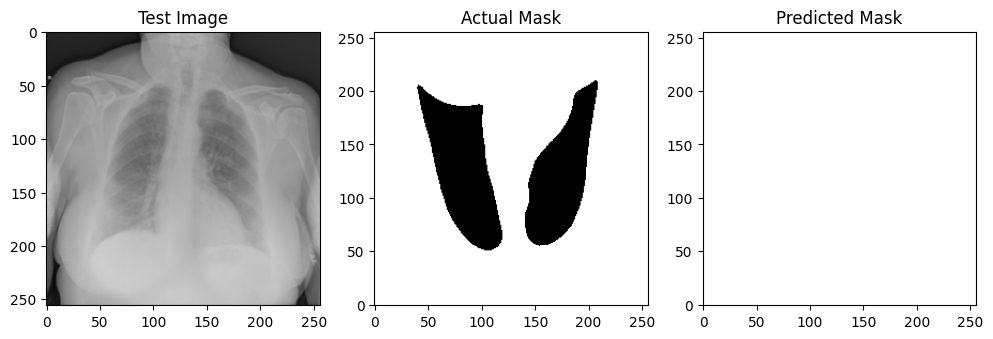

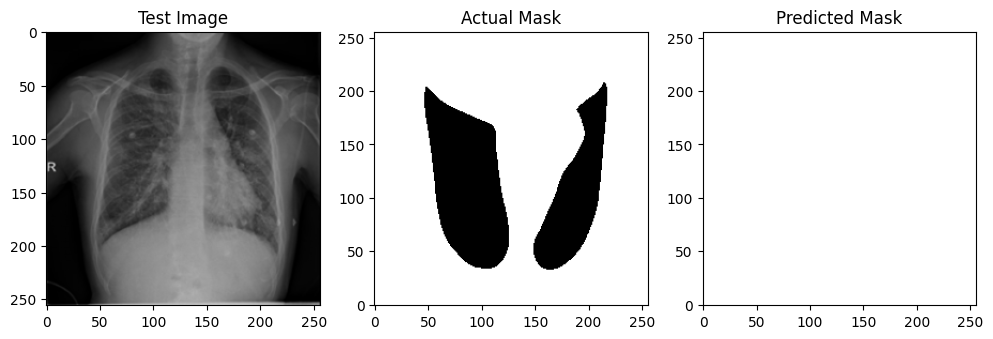

In [10]:
c_dm.setup('test')
get_segmentation_plot(
    c_module.model, 
    c_dm.test, 
    device='cpu')

In [11]:
!tar -zcvf segmenter_logs.tar.gz /kaggle/working/logs

tar: Removing leading `/' from member names
/kaggle/working/logs/
/kaggle/working/logs/shenzen_segmenter/
/kaggle/working/logs/shenzen_segmenter/version_0/
/kaggle/working/logs/shenzen_segmenter/version_0/checkpoints/
/kaggle/working/logs/shenzen_segmenter/version_0/checkpoints/epoch=9-step=1590.ckpt
/kaggle/working/logs/shenzen_segmenter/version_0/metrics.csv
/kaggle/working/logs/shenzen_segmenter/version_0/hparams.yaml
/kaggle/working/logs/covid_segmenter/
/kaggle/working/logs/covid_segmenter/version_0/
/kaggle/working/logs/covid_segmenter/version_0/checkpoints/
/kaggle/working/logs/covid_segmenter/version_0/checkpoints/epoch=9-step=10170.ckpt
/kaggle/working/logs/covid_segmenter/version_0/metrics.csv
/kaggle/working/logs/covid_segmenter/version_0/hparams.yaml
/kaggle/working/logs/darwin_segmenter/
/kaggle/working/logs/darwin_segmenter/version_0/
/kaggle/working/logs/darwin_segmenter/version_0/checkpoints/
/kaggle/working/logs/darwin_segmenter/version_0/checkpoints/epoch=9-step=17170

In [12]:
!tar -zcvf segmenter_results.tar.gz /kaggle/working/results

tar: Removing leading `/' from member names
/kaggle/working/results/
/kaggle/working/results/covid_segmenter.csv
/kaggle/working/results/shenzen_segmenter.csv
/kaggle/working/results/darwin_segmenter.csv
